In [48]:
import os
import pickle
import time
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.tools.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import KFold, StratifiedKFold, train_test_split
from sklearn.datasets.base import Bunch
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

About the Data

There are 4898 wines in the dataset with 12 features (fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol and quality).

All the features are numerical, even the quality that is based on a score of 0 to 10.

The main feature in the data set is the quality. The main idea is try to predict the quality of a wine. 

First, I download the data set: winequality-white.csv from the  UCI Machine Learning Repository.

In [49]:
WINE = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

In [50]:
def download_data(url, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)

In [51]:
download_data(WINE)

In [52]:
wine    = pd.read_csv('data/winequality-white.csv', sep=";")

In [53]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [54]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [55]:
X = wine[[
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide",
    "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"
]]
y = wine["quality"]

This is a classification data and since the values are already numerical, I can proceed to machine learning. The target in this wine quality.

Rebecca: Although Rank2D below is often used for regressional models, following the class tutorial, I applied it regardless. The point here was to learn what I could and your feed essentiall has helped but I looked it after that and saw this interesting thing with the correlation that I got. In this case a Pearson correlation of 1.0 means that there is a strong positive, linear relationship between the pairs of features and a value of -1.0 indicates a strong negative, linear relationship (a value of zero indicates no relationship). In the chart below, I am looking for dark red and dark blue boxes to identify further.

The density seems to be correlated with the residual sugar. So lets insclude these ones in the investigation features

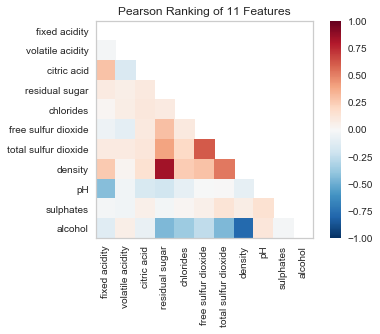

In [56]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
visualizer.poof()

A further investigation of the above using the jointplotvisualizer. Clearly there aren't much outliers.

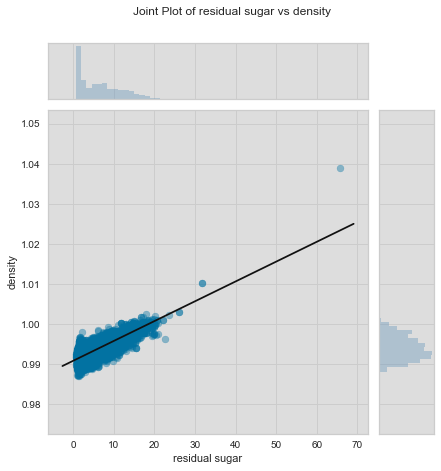

In [57]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='residual sugar', target='density')
visualizer.fit(X['residual sugar'], X['density'])
visualizer.poof()

For classification, linear regression is not the right approach as it will give too much weight to data far from the decision frontier. 

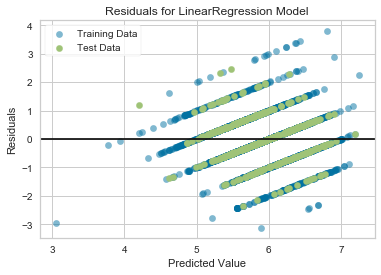

In [58]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1
)

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

[Rebecca: Although I was blindly following the example from the class just simply understand what I missed, I realize that the Prediction error is purely a regression model application...] The graph below shows that quality has most values concentrated in the categories 5, 6 and 7. Only a small proportion is in the categories [3, 4] and [8] and none in the categories [1, 2] and [9,10].

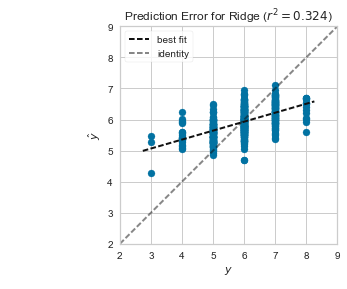

In [59]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(Ridge(alpha=3.181))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [60]:
names = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    'quality'

]

wine = os.path.join('data','winequality-white.csv')
data   = pd.read_csv(wine, sep=";")
data.columns = names
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [61]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [62]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
target   = ['quality']

X = data[features]
y = data[target]

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = [col for col in columns]
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])

        return output

In [64]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())),
         ('one_hot_encoder', OneHotEncoder()),
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)

    expected  = y
    predicted = model.predict(X)

    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted, labels=None, pos_label=1, average='micro', sample_weight=None))

In [65]:
# Try them all!
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [66]:
model_selection(X, y, LinearSVC())

0.91506737443854635

In [67]:
model_selection(X, y, SVC())

0.44875459371171905

In [68]:
model_selection(X, y, SGDClassifier())

0.77153940383830133

In [69]:
model_selection(X, y, KNeighborsClassifier())

0.66884442629644758

In [70]:
model_selection(X, y, BaggingClassifier())

0.97917517354022054

In [71]:
model_selection(X, y, ExtraTreesClassifier())

1.0

In [72]:
model_selection(X, y, RandomForestClassifier())

0.98632094732543896

Since F1 scores are at their best when value is at 1 and worst at 0; it could be determined that the extratreeclassifier is probably the best model selection withh closely behind: baggingclassifier and randomforestclassifier

In [73]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visual_model_selection(X, y, estimator):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())),
         ('one_hot_encoder', OneHotEncoder()),
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(model, score=['0','10'])
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.poof()

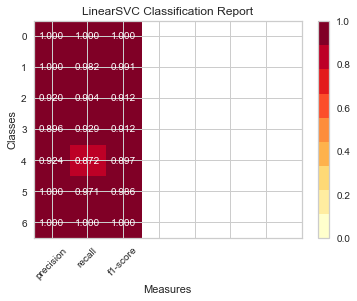

In [74]:
visual_model_selection(X, y, LinearSVC())

C:\Users\mytri\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


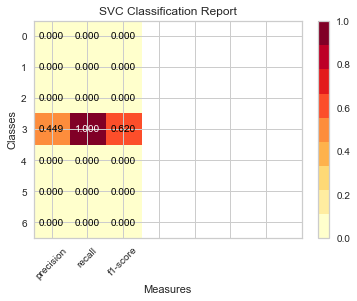

In [75]:
visual_model_selection(X, y, SVC())

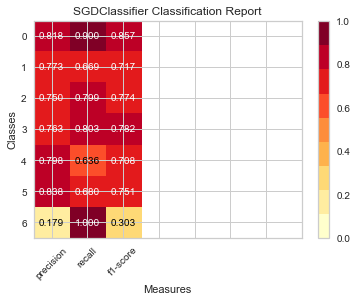

In [76]:
visual_model_selection(X, y, SGDClassifier())

C:\Users\mytri\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


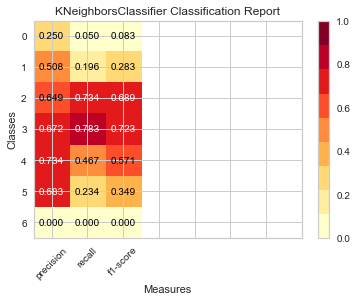

In [77]:
visual_model_selection(X, y, KNeighborsClassifier())

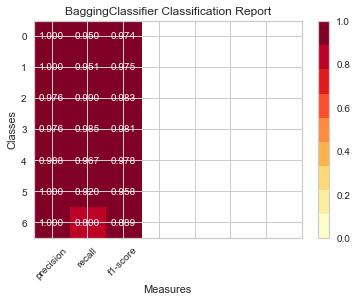

In [78]:
visual_model_selection(X, y, BaggingClassifier())

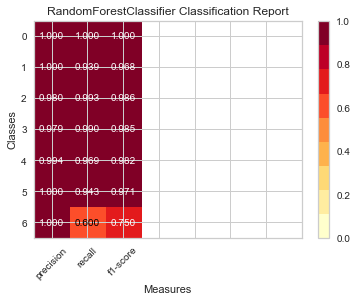

In [79]:
visual_model_selection(X, y, RandomForestClassifier())